In [420]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy import pi, sin, cos, dot

class ThinFilm_model:
    def __init__(self, ambient, thinfilm, substrate):
        self.ambient = ambient['a']
        self.thinfilm = thinfilm
        self.substrate = substrate['s']

    def eq_tf_matrix(self, wavelength):
        eq_matrix = identity_matrix(wavelength)
        for i in range(np.size(self.thinfilm)):
            eq_matrix = matrix_dot(tf_matrix(self.thinfilm[-i-1], wavelength), eq_matrix)
        return eq_matrix

    def eq_admittance(self, wl):
        eq_matrix = self.eq_tf_matrix(wl)
        eq_y = bc(eq_matrix, self.substrate, wl)
        Y = eq_y['C']/eq_y['B']
        return Y.values.reshape(np.size(wl), 1)
        
    def R(self, wl):
        eq_Y = self.eq_admittance(wl)
        r = (self.ambient-eq_Y)/(self.ambient+eq_Y)
        reflectance = np.reshape(r*r.conjugate(), np.size(eq_Y))
        return np.real(reflectance)

def bc(eq, ns, wl):
    bc = pd.DataFrame(np.reshape(dot(eq, np.array([[1], [ns]])), (np.size(wl), 2)),columns = ['B','C'])
    return bc

def chromatic_n(m, wl):
    n, k = globals()[material[m]['type']](material[m], wl)
    return n + 1j*k

def tf_matrix(layer, wl):
    m = matrix(layer['m'], layer['d'], wl)
    return m

def matrix_(m, t, wl):
    ita = chromatic_n(m, wl) 
    delta = 2*pi*ita*t/wl
    element = matrix_element(ita, delta)
    return np.reshape(element.values.reshape(1,-1), (np.size(wl), 2, 2))

def matrix_element(ita, delta):
    e = pd.DataFrame(
        {'e1':cos(delta), 'e2':1j/ita*sin(delta), 
         'e3':1j*ita*sin(delta), 'e4':cos(delta)})
    return e
    
def matrix_dot(layer_up, layer_bot): 
    w, _, _ = np.shape(layer_up)
    eq = [dot(layer_up[i], layer_bot[i]) for i in range(w)]
    return eq    

def identity_matrix(wl):
    m = np.size(wl)
    i = pd.DataFrame({'e1':np.ones(m), 'e2':np.zeros(m), 'e3':np.zeros(m), 'e4':np.ones(m)})
    i_matrix = np.reshape(i.values.reshape(1,-1), (m, 2, 2))
    return i_matrix


material = {
    'TiO2':{'A':5.913, 'B':0.2441, 'C':0.0803, 'type':'TiO2'},
    'SiO2':{'A':0.6961663,'B':0.0684043,'C':0.4079426,'D':0.1162414,'E':0.8974794,'F':9.896161, 'type':'SiO2'},
    'glass':{},
    'ITO':{'type':'ITO', 'material':'ITO'},
    'SiN':{'type':'SiN', 'material':'SiN'},
    'acrylic':{'A':1.1819, 'B':0.011313, 'type':'acrylic'},
    'acrylic_h':{'type':'acrylic_h'},
    'polymide':{'type':'polymide'}
}
def ITO(m, x):
    file = pd.read_csv('{}.csv'.format(m['material']))
    f_n = interp1d([float(i) for i in file[:381]['wl']], [float(i) for i in file[:381]['n']])
    f_k = interp1d([float(i) for i in file[:381]['wl']], [float(i) for i in file[382:]['n']])
    return f_n(x/1000), f_k(x/1000)

def SiN(m,x):
    file = pd.read_csv('{}.csv'.format(m['material']))
    f_n = interp1d([float(i) for i in file[:146]['wl']], [float(i) for i in file[:146]['n']])
    f_k = interp1d([float(i) for i in file[:146]['wl']], [float(i) for i in file[147:]['n']])
    return f_n(x/1000), f_k(x/1000)

def TiO2(m, x):
    x = x/1000
    return (m['A']+m['B']/(x**2-m['C']))**.5

def SiO2(m, x):
    x = x/1000
    n = (1+m['A']/(1-(m['B']/x)**2)+m['C']/(1-(m['D']/x)**2)+m['E']/(1-(m['F']/x)**2))**.5
    k = np.zeros(np.size(x))
    return n, k

def acrylic(m, x):
    x = x/1000
    n = (1+m['A']/(1-m['B']/x**2))**.5
    k = np.zeros(np.size(x))
    return n, k

def acrylic_h(m, x):
    n = 1.8*np.ones(np.size(x))
    k = 0*np.ones(np.size(x))
    return n, k

def polymide(m, x):
    n = 1.5*np.ones(np.size(x))
    k = np.zeros(np.size(x))
    return n, k

def sec_reflec(T_measure, n0, ns):
    T_sec = 1-((n0-ns)/(n0+ns))**2
    return (100/T_measure - 1/T_sec + 1)**-1

def trans(n0, n1):
    return 1-((n0-n1)/(n0+n1))**2

In [421]:
T_OCA_GG3 = trans(1.48, 1.47)
file = pd.read_csv(r'C:\Users\hsuyoway\Desktop\Yoway\DX\Glass_0T.csv')
file_c = pd.read_csv(r'C:\Users\hsuyoway\Desktop\Yoway\DX\DX-MP-1_0T.csv')
wl = file['nm']
TA_glass = sec_reflec(file['SCAN'], 1, 1.47)
TA_DX = sec_reflec(file_c['SCAN'], 1, 1.47)
f_gg3 = interp1d(wl, TA_glass)
f_dx = interp1d(wl, TA_DX)

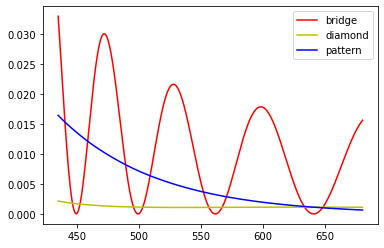

In [466]:
d_SiN = 10
d_SiO2 = 50
bridge = ThinFilm_model(
    {'a': 1.5}, [
        {'m': 'polymide', 'd': 800},
        {'m': 'SiN', 'd': d_SiN},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'ITO', 'd':23},
        {'m': 'acrylic_h', 'd':1200},
        {'m': 'ITO', 'd':23},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'SiN', 'd': d_SiN}
    ], {'s': 1.5})

ITO_layer = ThinFilm_model(
    {'a': 1.5}, [
        {'m': 'polymide', 'd': 2000},
        {'m': 'SiN', 'd': d_SiN},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'ITO', 'd':23},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'SiN', 'd': d_SiN}
    ], {'s': 1.5})

pattern = ThinFilm_model(
    {'a': 1.5}, [
        {'m': 'polymide', 'd': 2000},
        {'m': 'SiN', 'd': d_SiN},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'SiN', 'd': d_SiN}
    ], {'s': 1.5})

start_wl = 435
end_wl = 680
wl = np.linspace(start_wl, end_wl, 1000)
R_b = bridge.R(wl)
R_ITO = ITO_layer.R(wl)
R_p = pattern.R(wl)

plt.plot(wl, R_b, 'r',label = 'bridge', )
plt.plot(wl, R_ITO, 'y', label = 'diamond')
plt.plot(wl, R_p, 'b', label = 'pattern')
plt.legend(loc = 'best')
plt.savefig('model.png')
plt.show()

In [405]:
OG145 = R_b

In [408]:
OG150 = R_b

In [415]:
OG165 = R_b

In [419]:
OG170 = R_b

In [423]:
OG180 = R_b

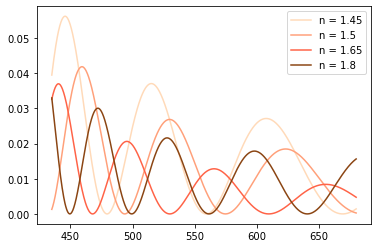

In [449]:
plt.plot(wl, OG145, 'peachpuff' ,label = 'n = 1.45')
plt.plot(wl, OG150, 'lightsalmon',label = 'n = 1.5')
plt.plot(wl, OG165, 'tomato',label = 'n = 1.65')
#plt.plot(wl, OG170, label = 'n = 1.7')
plt.plot(wl, OG180, 'saddlebrown',label = 'n = 1.8')
plt.legend(loc = 'best')
plt.savefig('index.png')
plt.show()

